In [ ]:
%env CUDA_VISIBLE_DEVICES=1

### Check BC prediction class balance

In [3]:
import json
from pathlib import Path
from collections import Counter

In [ ]:
for exp_dir in Path("final_exp").glob("*Meta-Llama-3.1-8B*batch-calibration*2-shot"):
    n_format_evaluated_list = []
    print(exp_dir)

    for filename in sorted(exp_dir.glob("metadataholistic*task1423*.json")):
        tasknum = [part for part in str(filename).split("_") if "task" in part][0]
        print("\t", tasknum, sep="")
        with open(filename, "r") as f:
            res = json.load(f)

        for format, accuracy_and_logs in res["metadata"]["nodes"].items():
            acc_dict, logs = accuracy_and_logs
            generations = [sample["generation"] for sample in logs]
            answer_counts = Counter(generations)
            print(answer_counts)
    #     n = len(res["all_structured_prompt_formats_accuracies"])
    #     n_format_evaluated_list.append(n)

    #     # print(n, filename.stem)

    # counter = Counter(n_format_evaluated_list)
    # print(exp_dir.name)
    # for format_amount, count in counter.items():
    #     print(f"\t{format_amount:2d} --> {count:2d}")

In [ ]:
for exp_dir in Path("final_exp").glob("*Llama-3.2-3B-Instruct_lora*"):
    n_format_evaluated_list = []
    print(exp_dir)

    for filename in sorted(exp_dir.glob("metadataholistic*task1423*.json")):
        tasknum = [part for part in str(filename).split("_") if "task" in part][0]
        print("\t", tasknum, sep="")
        with open(filename, "r") as f:
            res = json.load(f)

        for format, accuracy_and_logs in res["metadata"]["nodes"].items():
            acc_dict, logs = accuracy_and_logs
            generations = [sample["generation"] for sample in logs]
            answer_counts = Counter(generations)
            print(answer_counts)
    #     n = len(res["all_structured_prompt_formats_accuracies"])
    #     n_format_evaluated_list.append(n)

    #     # print(n, filename.stem)

    # counter = Counter(n_format_evaluated_list)
    # print(exp_dir.name)
    # for format_amount, count in counter.items():
    #     print(f"\t{format_amount:2d} --> {count:2d}")

### Work with csv-form experiment results

In [18]:
import pandas as pd

df = pd.read_csv("big_table.csv")

df.shape

(416, 33)

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme(style="whitegrid")
sns.set_theme(font_scale=1.4, style='ticks', rc={
    "grid.linewidth": 1.8,
    "axes.edgecolor": "black",
})

%config InlineBackend.figure_format = "svg"

In [20]:
from pathlib import Path
import json

root_dir = Path("train_test_splits/random")

tasknum_to_format_length = {}

for format_filename in root_dir.glob("*nodes_10*.json"):
    tasknum = [part for part in str(format_filename).split("_") if "task" in part][0]
    with open(format_filename, "r") as f:
        res = json.load(f)
    format_length = len(res["test_formats"][0])
    tasknum_to_format_length[tasknum] = format_length

df["format_length"] = df["task"].map(tasknum_to_format_length)


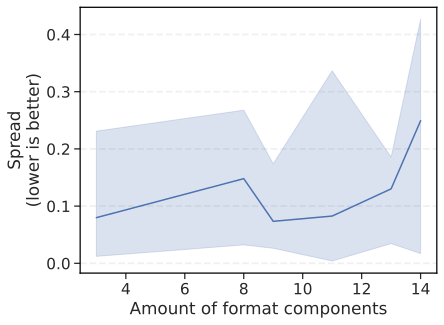

In [28]:
ax = sns.lineplot(data=df, x="format_length", y="spread_accuracy", errorbar=("pi", 90))
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.xlabel("Amount of format components")
plt.ylabel("Spread\n(lower is better)")
plt.savefig("plots_and_tables/format_length_vs_spread.png", bbox_inches="tight", dpi=300)
plt.show()

In [19]:
TASKS = [
    "task1423",     # mathqa, geometry
    "task1419",     # mathqa, gain
    "task1420",     # mathqa, general
    "task322",      # does the sentence contain a threat
    "task323",      # is the sentence sexually explicit
    "task296",      # story completion
    "task1387",     # anli, entailment
    "task161",      # count number of words containing letter X
    "task114",      # is X the longest word in the sentence
    "task320",      # race stereotypes
]

In [ ]:
df = df[df["task"].isin(TASKS)]
aggregated = df.groupby(["model", "method"])[["median_accuracy", "spread_accuracy", "std_accuracy", "size"]].mean()
aggregated = aggregated.reset_index()
aggregated = aggregated[aggregated["method"].isin(["FS"])]
aggregated = aggregated.sort_values("size")
aggregated

In [ ]:

# aggregated = aggregated[aggregated["method"] != "TE"]

plt.figure(figsize=(10, 3))
ax = sns.barplot(aggregated, x="model", y="median_accuracy", hue="method", errorbar=None)
plt.xticks(rotation=25, ha="right")

# mean_stds = aggregated["std_accuracy"]
aggregated.loc[:, "method"] = pd.Categorical(values=aggregated["method"], categories=["(new) TE", "FS", "TE"])
mean_stds = aggregated.sort_values(["method", "model"])["std_accuracy"]
for i, (p, mean_std) in enumerate(zip(ax.patches, mean_stds)):
    x = p.get_x()
    w = p.get_width()
    h = p.get_height()
    plt.errorbar(x + w / 2, h, yerr=2 * mean_std, fmt="none", linewidth=1, color="black", capsize=2)
    # plt.text(x + w / 2, h + 0.1, f"{i}\n{mean_std:.3}", fontsize=6)

plt.savefig("greedy_decoding.png", bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
plt.figure(figsize=(10, 3))
sns.barplot(aggregated, x="model", y="spread_accuracy", hue="method")
plt.xticks(rotation=15, ha="right")
plt.show()

In [ ]:
aggregated

### Check GPT-4.1 / DeepSeek results

In [ ]:
import json
from pathlib import Path
import pandas as pd
import numpy as np

def load_json(path):
    with open(path, "r") as f:
        return json.load(f)

root_paths = [
    ("deepseek", Path("exp/deepseek/deepseek-chat-v3-0324")),
    ("gpt-4.1", Path("exp/gpt-4.1-2025-04-14")),
]

# Dictionary to store all metrics for each model
model_data = {}

for model_name, root_path in root_paths:
    task_subdirs = sorted(
        [p for p in root_path.glob("*") if p.is_dir() and "task" in p.stem],
        key=lambda path: int(
            [part for part in str(path.name).split("_") if "task" in part][0][len("task"):]
        )
    )
    
    task_names = [p.stem for p in task_subdirs]
    
    ensemble_accuracies = []
    few_shot_accuracies = []
    ensemble_spreads = []
    few_shot_spreads = []
    ensemble_std_accuracies = []
    few_shot_std_accuracies = []
    
    for task_subdir in task_subdirs:
        summary = load_json(task_subdir / "summary.json")
        ensemble_accuracies.append(summary["ensemble_median_accuracy"])
        few_shot_accuracies.append(summary["median_accuracy"])
        ensemble_spreads.append(summary["ensemble_spread"])
        few_shot_spreads.append(summary["spread"])
        ensemble_std_accuracies.append(summary["ensemble_std_accuracy"])
        few_shot_std_accuracies.append(summary["std_accuracy"])
    
    # Store all lists for this model
    model_data[model_name] = {
        'tasks': task_names,
        'ensemble_accuracies': ensemble_accuracies,
        'few_shot_accuracies': few_shot_accuracies,
        'ensemble_spreads': ensemble_spreads,
        'few_shot_spreads': few_shot_spreads,
        'ensemble_std_accuracies': ensemble_std_accuracies,
        'few_shot_std_accuracies': few_shot_std_accuracies
    }
    
    # Verify lengths are all equal
    assert len(ensemble_accuracies) == \
        len(few_shot_accuracies) == \
        len(ensemble_spreads) == \
        len(few_shot_spreads) == \
        len(ensemble_std_accuracies) == \
        len(few_shot_std_accuracies) == \
        len(task_names) == 10

# Create DataFrame using the collected data
all_data = []
for model_name in model_data:
    model_metrics = model_data[model_name]
    for i in range(len(model_metrics['tasks'])):
        task_data = {
            'task': model_metrics['tasks'][i],
            'model': model_name,
            "method": "FS",
            'accuracy': model_metrics['few_shot_accuracies'][i],
            'spread': model_metrics['few_shot_spreads'][i],
            'std_accuracy': model_metrics['few_shot_std_accuracies'][i]
        }
        all_data.append(task_data)

    for i in range(len(model_metrics['tasks'])):
        task_data = {
            'task': model_metrics['tasks'][i],
            'model': model_name,
            'method': "Maj",
            'accuracy': model_metrics['ensemble_accuracies'][i],
            'spread': model_metrics['ensemble_spreads'][i],
            'std_accuracy': model_metrics['ensemble_std_accuracies'][i]
        }
        all_data.append(task_data)

# Create DataFrame
df = pd.DataFrame(all_data)

# Compute statistics per model
stats = df.groupby(['method', 'model']).agg({
    'accuracy': ['mean'],
    'std_accuracy': ['mean'],
    'spread': ['mean'],
    # 'accuracy': ['min', 'mean', 'max'],
    # 'spread': ['min', 'mean', 'max'],
    # 'std_accuracy': ['min', 'mean', 'max']
}).round(4)#.reorder_levels([1, 0], axis=1).stack().reorder_levels([1, 0], axis=0).sort_index(level=0)

print("DataFrame shape:", df.shape)
print("\nStatistics per model:")

with open("plots_and_tables/frontier_models/table.tex", "w") as f:
    f.write(stats.to_latex(bold_rows=False, float_format="%.3f"))

stats

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(font_scale=1.4, style='ticks', rc={
    "grid.linewidth": 1.8,
    "axes.edgecolor": "black",
})
# sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

%config InlineBackend.figure_format = 'svg'

In [ ]:
few_shot_color = sns.color_palette("Set2")[0]
ensemble_color = sns.color_palette("Set2")[3]
few_shot_color, ensemble_color

In [ ]:

# Create the bar plot
task_numbers = [name[4:] for name in task_names]
sns.barplot(x=task_numbers, y=ensemble_accuracies, alpha=0.7, label="Ensemble", color=ensemble_color)
ax = sns.barplot(x=task_numbers, y=few_shot_accuracies, alpha=0.7, label="Few-shot", color=few_shot_color)

for i, (few_shot, ensemble) in enumerate(zip(few_shot_accuracies, ensemble_accuracies)):
    change = ensemble - few_shot
    ax.text(i, max(ensemble, few_shot) + 0.02, f'{change:+.3f}', color="green" if change > 0 else "red",
            ha='center', va='center', rotation=0, fontsize=12)

model = "gpt-4.1" if "gpt-4.1" in str(root_path) else "deepseek-chat-v3-0324"
plt.title(f"Ensemble vs Few-shot Accuracy, {model}")
plt.ylabel("Accuracy")
plt.xlabel("Task index")
plt.legend()
plt.savefig(f"plots_and_tables/frontier_models/{model}-ensemble-vs-few-shot-accuracy.png", bbox_inches="tight", dpi=350)
plt.show()

In [ ]:

# Create the bar plot
plt.figure(figsize=(10, 4.5))
ax = sns.barplot(x=task_numbers, y=few_shot_spreads, alpha=1, label="Few-shot", color=few_shot_color)
ax2 = sns.barplot(x=task_numbers, y=ensemble_spreads, alpha=1, label="Ensemble", color=ensemble_color, edgecolor="black")
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
# plt.setp(ax2.patches, linewidth=0.5, edgecolor="black")
plt.ylim(0, 0.103)

for i, (few_shot, ensemble) in enumerate(zip(few_shot_spreads, ensemble_spreads)):
    change = (ensemble - few_shot) / few_shot * 100
    # ax.arrow(i, few_shot, 0, ensemble - few_shot, color="tab:green" if change < 0 else "tab:red", 
            #  length_includes_head=True)
    ax.text(i, max(ensemble, few_shot) + 0.002, f'{change:+.1f}%', color="green" if change < 0 else "red",
            ha='center', va='center', rotation=0, fontsize=12)

mapper = {
    "deepseek-chat-v3-0324": "DeepSeek V3 0324",
    "gpt-4.1": "GPT-4.1"
}

# plt.title(f"Ensemble vs few-shot spread, {mapper[model]}\n(lower is better)")
plt.ylabel("Spread (lower is better)")
plt.xlabel("Task index")
plt.legend()
plt.savefig(f"plots_and_tables/frontier_models/{model}-ensemble-vs-few-shot-spread.png", bbox_inches="tight", dpi=350)
plt.show()

In [ ]:

# Create the bar plot
ax = sns.barplot(x=task_names, y=few_shot_std_accuracies, alpha=0.5, label="Few-shot", color=ensemble_color)
sns.barplot(x=task_names, y=ensemble_std_accuracies, alpha=0.5, label="Ensemble", color=few_shot_color)

for i, (few_shot, ensemble) in enumerate(zip(few_shot_std_accuracies, ensemble_std_accuracies)):
    change = (ensemble - few_shot) / few_shot * 100
    ax.text(i, max(ensemble, few_shot) + 0.002, f'{change:+.1f}%', color="green" if change < 0 else "red",
            ha='center', va='center', rotation=0, fontsize=12)

plt.title(f"Ensemble vs Few-shot standard deviation of accuracy, {model}\n(lower is better)")
plt.ylabel("Standard deviation of accuracy")
plt.legend()
plt.savefig(f"plots_and_tables/frontier_models/{model}-ensemble-vs-few-shot-std-accuracy.png", bbox_inches="tight", dpi=350)
plt.show()

### Example plots

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Sample data generation (same as before)
np.random.seed(42)
models = [f'Model {i+1}' for i in range(8)]
methods = [f'Method {j+1}' for j in range(5)]

data = []
for model in models:
    for method in methods:
        performance = np.random.uniform(0.6, 0.95)
        spread = np.random.uniform(0.01, 0.05)
        data.append([model, method, performance, spread])

df = pd.DataFrame(data, columns=['Model', 'Method', 'Performance', 'Spread'])

# --- Faceted plot setup ---
# We use pointplot to show mean + error bars per method per model
g = sns.FacetGrid(df, col="Model", col_wrap=4, height=3.5, sharey=True)

# Each facet is a point plot of method vs. performance with error bars
g.map_dataframe(sns.pointplot, 
                x="Method", 
                y="Performance", 
                errorbar=None,  # we handle error manually
                order=methods,  # keep consistent order
                markers="o")

# Add error bars manually
for ax, model in zip(g.axes.flat, models):
    model_data = df[df["Model"] == model]
    for i, method in enumerate(methods):
        point = model_data[model_data["Method"] == method]
        perf = point["Performance"].values[0]
        spread = point["Spread"].values[0]
        ax.errorbar(i, perf, yerr=spread, fmt='none', capsize=3, color='black')

# Styling
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_ylim(0.5, 1.0)

g.fig.suptitle("Performance per Method for Each Model", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Example data setup
models = ['Model A', 'Model B', 'Model C']
scenarios = ['Scenario 1', 'Scenario 2', 'Scenario 3']

# Method-under-test (scenario-dependent)
data = []
for model in models:
    for scenario in scenarios:
        perf = np.random.uniform(0.7, 0.9)
        spread = np.random.uniform(0.01, 0.05)
        data.append([model, scenario, perf, spread])
df = pd.DataFrame(data, columns=['Model', 'Scenario', 'Performance', 'Spread'])

# Reference method (scenario-independent)
reference_perf = {
    model: np.random.uniform(0.75, 0.85) for model in models
}
reference_spread = {
    model: np.random.uniform(0.01, 0.03) for model in models
}

# --- Plotting ---
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

for i, model in enumerate(models):
    ax = axes[i]
    model_df = df[df['Model'] == model]
    
    sns.barplot(
        data=model_df,
        x='Scenario',
        y='Performance',
        ax=ax,
        yerr=model_df['Spread'],  # OR use matplotlib errorbar for more control
        capsize=0.1,
        color='skyblue'
    )
    
    # Reference line
    ref_perf = reference_perf[model]
    ax.axhline(y=ref_perf, linestyle='--', color='red', label='Reference Method')
    
    # Optional: Reference error band
    ref_spread = reference_spread[model]
    ax.fill_between(
        [-0.5, 2.5],  # x-range
        [ref_perf - ref_spread]*2,
        [ref_perf + ref_spread]*2,
        color='red',
        alpha=0.2
    )
    
    ax.set_title(model)
    ax.set_ylim(0.6, 1.0)
    if i == 0:
        ax.set_ylabel('Performance')
    ax.set_xlabel('')
    ax.legend(loc='lower right')

fig.suptitle("Tested Method vs. Reference Method Across Scenarios", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In [ ]:
import pandas as pd

df = pd.read_csv("big_table.csv")

df.columns

In [3]:
subset = df[df.setting == "uniform"]

In [ ]:
df.setting.value_counts()

In [ ]:
df.setting.value_counts() / 52

In [ ]:
df = pd.read_csv("big_table.csv")
spread_by_setting_task = df.groupby(["setting", "task"])[["spread"]].mean()
spread_by_setting_task.groupby("setting").apply(lambda x: x.nlargest(5, "spread"))

In [14]:
import json
from pathlib import Path

hard_tasks = ["task1297", "task214", "task297", "task296", "task213"]

root_dir = Path("../natural-instructions/tasks/")

paths = [p for p in root_dir.glob("*.json")]
paths = [p for p in paths if any(task in p.stem for task in hard_tasks)]

def load_json(path):
    with open(path, "r") as f:
        return json.load(f)

with open("task_analysis.txt", "w") as f:
    for p in paths:
        task = load_json(p)
        print(p, file=f)
        print(task["Definition"], file=f)
        # print(task["Positive Examples"], file=f)
        # print(task["Negative Examples"], file=f)
        print("=" * 100, "\n\n", file=f)



In [15]:
splits_dir = Path("train_test_splits/random")

tasknum2formatlength = {}

for config_file in splits_dir.glob("*.json"):
    config = load_json(config_file)
    tasknum = [part for part in (config_file.stem).split("_") if "task" in part][0]
    formatlength = len(config["test_formats"][0])
    tasknum2formatlength[tasknum] = formatlength

In [17]:
df["format_length"] = df["task"].map(tasknum2formatlength)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.3)

plt.figure(figsize=(13, 5))
sns.stripplot(df[df["setting"] == "uniform"], x="format_length", y="spread")
# sns.barplot(df)

In [3]:
def q05(x):
    return x.quantile(0.05)

def q95(x):
    return x.quantile(0.95)


In [ ]:
spread_vs_length = df[df["setting"] == "uniform"].groupby("format_length")["spread"].agg(["mean", "std", q05, q95])

plt.figure(figsize=(7, 4), dpi=350)
plt.plot(spread_vs_length.index, spread_vs_length["mean"])
plt.fill_between(
    spread_vs_length.index,
    y1=spread_vs_length["q05"],
    y2=spread_vs_length["q95"],
    alpha=0.3
)
# upper_error = spread_vs_length["q95"] - spread_vs_length["mean"]
# lower_error = spread_vs_length["mean"] - spread_vs_length["q05"]

# plt.errorbar(
#     x=spread_vs_length.index,
#     y=spread_vs_length["mean"],
#     yerr=[lower_error, upper_error],
#     color="black"
# )
plt.xlabel("# format components")
plt.ylabel("Spread")
plt.title("Spread vs amount of prompt components\n90% confidence interval")
plt.savefig("iid_plots/spread_vs_amount_format_components.png", bbox_inches="tight", dpi=350)

In [ ]:
spread_vs_size = df[df["setting"] == "uniform"].groupby("size")["spread"].agg(["mean", q05, q95])

plt.figure(figsize=(7, 4), dpi=350)
plt.plot(spread_vs_size.index, spread_vs_size["mean"])
plt.fill_between(
    spread_vs_size.index,
    y1=spread_vs_size["q05"],
    y2=spread_vs_size["q95"],
    alpha=0.3
)

plt.xlabel("Model size")
plt.ylabel("Spread")
plt.title("Spread vs model size\n90% confidence interval")
plt.savefig("iid_plots/spread_vs_model_size.png", bbox_inches="tight", dpi=350)

### Renaming experiments

In [1]:
from pathlib import Path

root_dir = Path("exp")

for filename in root_dir.glob("*iid-exact-match-no-chat-template-2-shot"):
    if filename.is_dir():
        new_name = filename.parent / str(filename.name).replace(
            "iid-exact-match-no-chat-template-2-shot",
            "iidx2-exact-match-no-chat-template-2-shot"
        )
        filename.rename(new_name)

In [2]:
from pathlib import Path

root_dir = Path("exp")

for filename in root_dir.glob("*loraconsistency-loss-*"):
    if filename.is_dir():
        new_name = filename.parent / str(filename.name).replace("loraconsistency-loss-", "lora---consistency-")
        filename.rename(new_name)

In [3]:
from pathlib import Path

root_dir = Path("exp")

for filename in root_dir.glob("*-random-*"):
    if filename.is_dir():
        new_name = filename.parent / str(filename.name).replace("-random-", "-iidx2-")
        filename.rename(new_name)

### Experiment with imbalance-robust metrics

In [15]:
import json
import pandas as pd
from pathlib import Path
from typing import Dict
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score, accuracy_score

def read_json(path: str) -> Dict:
    with open(path, "r") as f:
        return json.load(f)

In [ ]:
# experiment_path = "final_exp/gemma-2-9b-it_lora---iidx2-no-chat-template-response-only-unbalanced-0-shot"
experiment_path = "final_exp/gemma-2-9b-it_lora---iidx2-no-chat-template-response-only-0-shot"

records = []

for name in Path(experiment_path).glob("metadata*.json"):
    result = read_json(name)

    nodes = result["metadata"]["nodes"]
    formats = list(nodes.keys())

    entries = nodes[formats[0]][1]
    y_true = [e["answer"] for e in entries]
    y_pred = [e["generation"] for e in entries]

    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    mattcorr = matthews_corrcoef(y_true, y_pred)

    record = {}
    record["accuracy"] = acc
    record["balanced_accuracy"] = bal_acc
    record["matthews_corrcoef"] = mattcorr
    record["task"] = [piece for piece in name.stem.split("_") if "task" in piece][0]
    records.append(record)

df = pd.DataFrame.from_records(records)

df
# print(f"Metrics:\n  Accuracy: {acc:.2f}\n  Balanced Accuracy: {bal_acc:.2f}\n  Matthew's Correlation: {mattcorr:.2f}")

In [26]:
from pathlib import Path

root_dir = Path("final_exp")

# Rename directories containing "-iid-" to use "-iidx2-" instead
for path in root_dir.glob("*-iid-*"):
    new_name = str(path).replace("-iid-", "-iidx2-")
    path.rename(new_name)


In [ ]:
df[["accuracy", "balanced_accuracy", "matthews_corrcoef"]].mean()

In [ ]:
df[["accuracy", "balanced_accuracy", "matthews_corrcoef"]].mean()

In [ ]:
import seaborn as sns

sns.color_palette("Paired")

### Debug prefix masking

In [ ]:
import torch
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-3B-Instruct")

def mask_non_predicted(labels, input_ids):
    masked_labels = labels.clone()
    for i in range(len(labels)):
        predicted_indices = (labels[i] != tokenizer.pad_token_id).nonzero(as_tuple=True)[0]

        if len(predicted_indices) > 0:
            first_predicted_idx = predicted_indices[0]
            masked_labels[i, :first_predicted_idx] = -100  # set all content before the predicted part eq -100
        else:
            masked_labels[i, :] = -100  

    return masked_labels



In [ ]:
text = "Hello what a beautiful day."
inputs = tokenizer(text, padding="max_length", max_length=16, return_tensors="pt")
inputs

In [ ]:
tokenizer.pad_token_id

In [ ]:
mask_non_predicted(inputs.input_ids, inputs.input_ids)

### Example of accuracy change

In [ ]:
import pandas as pd

In [ ]:
import pandas as pd
pd.set_option("display.max_colwidth", 100)

spreads = pd.read_csv("exp/Meta-Llama-3.1-8B-Instruct---iidx2-no-chat-template-0-shot/spreads.csv")

spreads = spreads.sort_values("spread", ascending=False)

spreads.head(10)[[
    "task",
    "best_accuracy",
    "worst_accuracy",
    "best_format",
    "worst_format"
]]

In [ ]:
spreads.head(5)[[
    "best_format",
    "worst_format"
]]

### Restructuring experiments dir

In [5]:
import os
from pathlib import Path

model_families = ["falcon", "gemma", "Llama", "Qwen"]
exp_root_dir = Path("exp")

In [ ]:
def restructure_experiments(exp_root_dir, model_families):
    "Assumes shallow structure, with all experiments in `exp` dir."

    # Create directories for each model family with subdirectories
    for family in model_families:
        family_dir = exp_root_dir / family
        family_dir.mkdir(exist_ok=True)
        
        # Create chat template subdirectories
        (family_dir / "chat_template").mkdir(exist_ok=True)
        (family_dir / "no_chat_template").mkdir(exist_ok=True)
        
        # Create setting subdirectories
        (family_dir / "chat_template" / "iid").mkdir(exist_ok=True)
        (family_dir / "chat_template" / "compositional").mkdir(exist_ok=True)
        (family_dir / "no_chat_template" / "iid").mkdir(exist_ok=True)
        (family_dir / "no_chat_template" / "compositional").mkdir(exist_ok=True)

    # Get all directories in exp_root_dir
    exp_dirs_list = [d for d in Path("exp").iterdir() if d.is_dir()]

    # Move directories to their appropriate subfolder based on experiment settings
    for dir_path in exp_dirs_list:
        dir_name = dir_path.name
        # Skip if it's one of the model family directories we just created
        if dir_name in model_families:
            continue
            
        # Check if directory starts with any of the model families
        for family in model_families:
            # if dir_name.startswith(family):
            if family in dir_name:
                # Determine chat template usage
                chat_template_dir = "no_chat_template" if "no-chat-template" in dir_name else "chat_template"
                
                # Determine experiment setting
                setting_dir = "iid" if "iid" in dir_name else "compositional"
                
                # Construct destination path
                dest_path = exp_root_dir / family / chat_template_dir / setting_dir / dir_name
                # Move the directory
                dir_path.rename(dest_path)
                print(f"Moved {dir_name} to {family}/{chat_template_dir}/{setting_dir}/")
                break

restructure_experiments(exp_root_dir, model_families)

In [7]:
def return_shallow_structure():
    for family in model_families:
        for template in ("chat_template", "no_chat_template"):
            for split in ("iid", "compositional"):
                for experiment in (Path(f"exp") / family / template / split).glob("*"):
                    parts = experiment.parts
                    assert parts[-4] == family
                    assert parts[-3] == template
                    assert parts[-2] == split
                    destination = experiment.parent.parent.parent.parent / experiment.name
                    experiment.rename(destination)

return_shallow_structure()

In [5]:
import pandas as pd
pd.set_option("display.width", 1000)
pd.set_option("display.max_colwidth", 300)

def get_family(exp, model_families):
    for family in model_families:
        if exp.startswith(family):
            return family
    return "?"

def get_shots(exp):
    if "2-shot" in exp:
        return "2"
    elif "0-shot" in exp:
        return "0"
    return "?"

def get_method(exp):
    if "lora" in exp and "iidx2" in exp:
        return "lora"
    elif "lora" in exp:
        return "lora_shift"
    elif "default" in exp:
        return "default_format"
    elif "sensitivity-aware-decoding" in exp:
        return "sensitivity-aware-decoding"
    elif "template-ensembles" in exp:
        return "template-ensembles"
    elif "batch-calibration-probs" in exp:
        return "batch-calibration-probs"
    elif "batch-calibration" in exp:
        return "batch-calibration"
    return "none"

def get_size(exp):
    expected_sizes = ["1B", "1.5B", "2b", "3B", "7B", "8B", "9b"]

    for size in expected_sizes:
        if size in exp:
            return size
    
    return "?"

def get_instruct(exp):
    if "Instruct" in exp or "it" in exp:
        return "Instruct"
    return "Base"

In [ ]:
experiments = []

for experiment in exp_root_dir.glob("*"):
    name = experiment.name

    if name in model_families:
        continue

    if "debug" in name or "rank1" in name:
        print(f"Skipping {name}")
        continue

    experiments.append(name)

records = [
    {
        "family": get_family(exp, model_families),
        "size": get_size(exp),
        "instruct": get_instruct(exp),
        "shots": get_shots(exp),
        "template": "no" if "no-chat-template" in exp else "chat-template",
        "split": "iid" if "iid" in exp else "compositional",
        "method": get_method(exp),
        "n_tasks_evaluated": len(list((exp_root_dir / exp).glob("metadataholistic*.json"))),
        "name": exp,
    }
    for exp in experiments
]

df = pd.DataFrame.from_records(records)

In [ ]:
df[
    (df.family == "gemma") & 
    (df.template == "no") & 
    (df["size"] == "2b") & 
    (df.shots.isin(("0", "2"))) & 
    (df.instruct == "Instruct")
].sort_values(["shots", "method"])

### Check number of evaluated tasks & formats 

In [3]:
import json
from pathlib import Path
from collections import Counter


In [ ]:
for format_split in ("iid", "compositional-separator-space"):
    subdir_path = f"final_exp/{format_split}"
    for cluster in Path(subdir_path).iterdir():
        if not cluster.is_dir():
            continue

        for experiment in cluster.iterdir():
            n_tasks = len(list(experiment.iterdir()))
            print(n_tasks, experiment)

            assert n_tasks == 52, "ERROR"
        

In [ ]:

# exp_dir = Path("final_exp/Meta-Llama-3.1-8B-Instruct_lora---iidx2-no-chat-template-response-only-0-shot")
# exp_dir = Path("final_exp/Meta-Llama-3.1-8B-Instruct---iidx2-split-batch-calibration-no-chat-template-response-only-0-shot")
# exp_dir = Path("final_exp/iid/base/gemma-2-2b-it---iid-no-chat-template-2-shot")

for exp_dir in Path("final_exp").glob("*Meta-Llama-3.1-8B*"):
    n_format_evaluated_list = []

    for filename in sorted(exp_dir.glob("metadataholistic*.json")):
        with open(filename, "r") as f:
            res = json.load(f)

        n = len(res["all_structured_prompt_formats_accuracies"])
        n_format_evaluated_list.append(n)

        # print(n, filename.stem)

    counter = Counter(n_format_evaluated_list)
    print(exp_dir.name)
    for format_amount, count in counter.items():
        print(f"\t{format_amount:2d} --> {count:2d}")

In [ ]:
for filename in Path("train_test_splits/random").glob("*.json"):
    with open(filename, "r") as f:
        config = json.load(f)

    print(len(config["test_formats"]), filename.stem)

### Renaming "_numnodes_9"

In [ ]:
import os
from pathlib import Path

def rename_files(root_dir):
    # Walk through all directories and files
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if '_numnodes_9_' in filename:
                old_path = os.path.join(dirpath, filename)
                new_filename = filename.replace('_numnodes_9_', '_numnodes_10_')
                new_path = os.path.join(dirpath, new_filename)
                os.rename(old_path, new_path)
                print(f"Renamed: {old_path} -> {new_path}")

# Run the renaming starting from current directory
rename_files('exp')


### Explore amount of formats per task/experiment

In [23]:
import json
from pathlib import Path

path = Path("exp/Llama-3.2-1B-Instruct_lora---simpleanswers-no-chat-template")

def load_json(path):
    with open(path, "r") as f:
        return json.load(f)

formats_evaluated_per_task = []
task_names = []

for filename in sorted(path.glob("*.json")):
    file = load_json(filename)
    n_formats_evaluated = len(file["all_structured_prompt_formats_accuracies"])
    formats_evaluated_per_task.append(n_formats_evaluated)
    tasknum = [part for part in filename.stem.split("_") if "task" in part][0]
    task_names.append(tasknum)

In [ ]:
splits_path = Path("train_test_splits/random")

for filename in sorted(splits_path.glob("*.json")):
    file = load_json(filename)
    tasknum = [part for part in filename.stem.split("_") if "task" in part][0]
    print(tasknum, len(file["test_formats"]))

In [ ]:
from collections import Counter

Counter(formats_evaluated_per_task)

In [ ]:
for n, task in zip(formats_evaluated_per_task, task_names):
    print(task, n)

### Explore class balance in Natural Instructions

In [ ]:
import json
from math import log
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)
%config InlineBackend.figure_format = "svg"

from generate_train_val_test_formats import TASK_NAMES

In [2]:

task_names = set(TASK_NAMES)

def load_json(path):
    with open(path, "r") as f:
        return json.load(f)

answer_counters = []

for path in Path("../natural-instructions/tasks/").glob("*.json"):
    task_num = str(path.stem).split('_')[0]
    if task_num not in task_names:
        continue

    task = load_json(path)

    answers = []
    for instance in task["Instances"]:
        assert isinstance(instance["output"], list) and len(instance["output"]) == 1, f"{path}\n{instance['output']}"
        answers.append(instance["output"][0])

    answer_counters.append(Counter(answers))

In [ ]:
task_sizes = [sum(counter.values()) for counter in answer_counters]

plt.hist(task_sizes)
plt.show()

In [ ]:
sorted(task_sizes)

In [3]:
def relative_entropy(counter):
    freqs = list(counter.values())
    probs = [f / sum(freqs) for f in freqs]
    n = len(probs)

    entropy = sum(-p * log(p) for p in probs)
    max_entropy = log(n)
    return entropy / max_entropy

In [4]:
balancedness = [relative_entropy(c) for c in answer_counters]

In [ ]:
plt.title("Class distribution entropy / (Maximal possible entropy)\nfor 53 tasks in Natural Instructions")
plt.scatter(range(len(balancedness)), balancedness)
plt.ylabel("Entropy / MaxEntropy")
plt.xlabel("Task index") 
plt.show()

### Exploring format structures for tasks

In [ ]:
import json
from pathlib import Path

def load_json(filename):
    with open(filename, "r") as f:
        return json.load(f)

In [2]:
action_type_sequences = []

root_dir = Path("train_test_splits/random")
for filename in root_dir.glob("*"):
    config = load_json(filename)
    action_type_sequences.append(
        (str(filename), config["action_types"])
    )

In [ ]:
max(action_type_sequences, key=lambda x: len(x[1]))

In [4]:
full = [name_seq for name_seq in action_type_sequences if len(set(name_seq[1])) == 6]

In [ ]:
len(full)

In [ ]:
sorted(full, key=lambda name_seq: -len(name_seq[1]))

In [8]:
action_types = ['chosen_space',
   'chosen_item_wrapper',
   'chosen_number_format',
   'chosen_space',
   'chosen_separator',
   'chosen_separator_text_and_option',
   'chosen_space',
   'chosen_space',
   'chosen_item_wrapper',
   'chosen_number_format',
   'chosen_space',
   'chosen_separator',
   'text_descriptor_fn',
   'chosen_separator']

In [ ]:
len(action_types)

### Checking dataset structure

In [ ]:
import pandas as pd

dataset = pd.read_csv("data/df_hermes_superclear.csv")

dataset.head()

### Checking answer probability aggregation

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

from utils import (
    _tokenize_prompts, 
    _tokenize_prompts_with_answers,
    get_ranking_based_generation_single_token_output_classes, 
    get_ranking_based_generation_multiple_token_output_classes
)

In [3]:
model_name = "unsloth/Llama-3.2-1B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
tokenizer("once upon a time...", add_special_tokens=False)["input_ids"]

In [ ]:
batch_size = 2
seq_len = 5
vocab_size = 128

logits = torch.arange(batch_size * seq_len * vocab_size).reshape(batch_size, seq_len, vocab_size).float()
logits = logits / logits.numel()
tokens = torch.randint(0, vocab_size, size=(batch_size, seq_len))

torch.gather(logits, dim=-1, index=tokens[..., None]).squeeze()

In [ ]:
manual = torch.empty(batch_size, seq_len)

for i in range(batch_size):
    for j in range(seq_len):
        manual[i, j] = logits[i, j, tokens[i, j]]

manual

In [ ]:
cumul_log_probs = torch.arange(2 * 3)

cumul_log_probs.reshape(2, 3)

In [ ]:
tokenizer.special_tokens_map

In [9]:
special_tokens_dict = {'pad_token': '<pad>'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
tokenizer.padding_side = "left"

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    cache_dir="/disk/4tb/seleznev/.cache/huggingface",
    # local_files_only=True,
    torch_dtype=torch.bfloat16
).eval().cuda()

model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id
model.generation_config.pad_token_id = tokenizer.pad_token_id

### Checking single token ranking function

In [15]:
prompts = [
    "Question: 2+2 equals?\nChoose correct option: A) 3 B) 4 C) 5.\nRespond with a single letter.",
    "Question: Is an elephant heavier than a mouse?\nChoose correct option:  A) yes B) no C) sometimes.\nRespond with in a single letter.",
    "Question: A synonim for the word 'rapid'?\nChoose correct option:  A) slow B) fast C) rap.\nRespond with in a single letter."
]

output_classes = ["A", "B", "C"]

In [ ]:
generation = get_ranking_based_generation_single_token_output_classes(prompts, output_classes, tokenizer, model)

In [ ]:
generation

In [ ]:
prompt = "2 + 2 = "

out = model.generate(**tokenizer(prompt, return_tensors="pt").to("cuda"), max_new_tokens=10)

generations = tokenizer.batch_decode(out)

for g in generations:
    print(g)

In [ ]:
prompt = prompts[1]

input_ids = tokenizer.apply_chat_template(
    [{"role": "user", "content": prompt}], 
    return_tensors="pt"
).to("cuda")

out = model.generate(input_ids, max_new_tokens=10)

generations = tokenizer.batch_decode(out)

for g in generations:
    print(g)

### Checking multi-token ranking function

In [14]:
prompts = [
    "Question: 2+2 equals? Choose correct option.\nOption 1: 3 Option 2: 4 Option 3: 5.",
    "Question: Is an elephant heavier than a mouse? Choose correct option.\nOption 1: yes Option 2: no Option 3: sometimes.",
    "Question: A synonim for the word 'rapid'? Choose correct option.\nOption 1: slow Option 2: fast Option 3: rap."
]

output_classes = ["Option 1", "Option 2", "Option 3"]

In [ ]:
generation = get_ranking_based_generation_multiple_token_output_classes(prompts[0], output_classes, tokenizer, model, batch_size_llm=2)

In [ ]:
generation

### Checking chat templating

In [ ]:
tokenizer.chat_template

In [11]:
special_tokens_dict = {'pad_token': '<pad>'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
tokenizer.padding_side = "left"

In [12]:
prompts = [
    "Q: Do pigs fly? (yes or no)\nA:",
    "Q: Is Everest higher than 9000 meters? (yes or no)\nA:",
    "Q: Is 2 + 2 = 4 correct? (yes or no):\nA:"
]

In [13]:
answers = ["yes", "no"]

In [14]:
inputs = _tokenize_prompts_with_answers(prompts, answers, tokenizer)

In [ ]:
inputs.input_ids.shape

In [ ]:
padded_text = tokenizer.batch_decode(inputs if isinstance(inputs, torch.Tensor) else inputs.input_ids)

for text in padded_text:
    print(text)
    print("="*30)